Importando bibliotecas

In [25]:
#%matplotlib inline  # Garante que as figuras do matplotlib sejam exibidas diretamente no Jupyter Notebook ou ambiente similar
# if using Theano with GPU
# os.environ["KERAS_BACKEND"] = "tensorflow"  # Define o backend do Keras como TensorFlow se estiver usando Theano com GPU (comentado porque não está sendo utilizado)

import os  # Importa o módulo os para interação com o sistema operacional
import random  # Importa o módulo random para operações relacionadas a números aleatórios
import numpy as np  # Importa o NumPy para operações com arrays e funções matemáticas
import keras  # Importa a biblioteca Keras para criação e treinamento de redes neurais
import matplotlib.pyplot as plt  # Importa o matplotlib.pyplot para criação de gráficos
from matplotlib.pyplot import imshow  # Importa a função imshow para exibir imagens
from keras.preprocessing import image  # Importa o módulo de pré-processamento de imagens do Keras
from keras.applications.imagenet_utils import preprocess_input  # Importa a função de pré-processamento específica para modelos ImageNet
from keras.models import Sequential  # Importa o modelo Sequential do Keras, que é uma pilha linear de camadas
from keras.layers import Dense, Dropout, Flatten, Activation  # Importa camadas de rede neural densa, dropout, achatamento e ativação
from keras.layers import Conv2D, MaxPooling2D  # Importa camadas de convolução e max pooling para redes neurais convolucionais
from keras.models import Model  # Importa a classe Model para criar modelos mais complexos que não são apenas sequenciais


In [26]:
root = "PetImages"
train_split, val_split = 0.7, 0.15

# Listar todas as categorias (subdiretórios) na pasta raiz
categories = [x[0] for x in os.walk(root) if x[0]][1:]

#print(categories)

In [27]:
# função auxiliar para carregar a imagem e retorná-la e o vetor de entrada
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregando todas as imagens da pasta raiz

In [28]:
data = []

for c, category in enumerate(categories):
    imagens = [os.path.join(dp, f) for dp, dn, filenames
               in os.walk(category) for f in filenames
               if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
    for cont, img_path in enumerate(imagens):
        try:
            img, x = get_image(img_path)
            frase_imagem = f"{cont}º imagem"
            #print(frase_imagem)
            
            try:
                data.append({'x':np.array(x[0]), 'y':c})
            except Exception as e:
                e = erro
                #print(f"Erro: {erro}")
                
        except Exception as erro:
            erro = erro
            #print(f"Erro: {erro}")
            
# Contando o número de classes
num_classes = len(categories)
#print(num_classes)

Randomizando a ordem dos dados

In [29]:
random.shuffle(data) # Boa prática, principalmente quando desejar dividir em treino, validação e teste

Criando divisão dos dados treinamento = 70%, validação = 15%, teste = 15%

In [30]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

print(f"Tamanho dos dados de treino {len(train)}")
print(f"Tamanho dos dados de validação {len(val)}")
print(f"Tamanho dos dados de teste {len(test)}")

Tamanho dos dados de treino 1399
Tamanho dos dados de validação 300
Tamanho dos dados de teste 300


Dados separados por rótulos

In [31]:
# Separando as entradas e rótulos para o conjunto de treino
x_train = np.array([t["x"] for t in train]) # Cria um array NumPy com as imagens de treino
y_train = [t["y"] for t in train]  # Cria uma lista com os rótulos de treino

# Separando as entradas e rótulos para o conjunto de validação
x_val = np.array([t["x"] for t in val]) # Cria um array NumPy com as imagens de validação
y_val = [t["y"] for t in val] # Cria uma lista com os rótulos de validação

# Separando as entradas e rótulos para o conjunto de teste
x_test = np.array([t["x"] for t in test]) # Cria um array NumPy com as imagens de teste
y_test = [t["y"] for t in test] # Cria uma lista com os rótulos de teste

#print(y_test)

Pré-processando os dados, certificando que sejam float32 e normalizados entre 0 e 1

In [32]:
# Normalizando dados
x_train = x_train.astype("float16") / 255
x_val = x_val.astype("float16") / 255
x_test = x_test.astype("float16") / 255

# Convertendo rótulos em One-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


Resumo dos dados

In [33]:
# Resumo
print(f"Carregado {len(data)} imagens e {num_classes} categorias")
print(f"Dados de treino = {len(x_train)} / validação = {len(x_val)} / teste = {len(x_test)}")
print(f"Forma dados de treinamento: {x_train.shape}")
print(f"Forma rótulos de treinamento: {y_train.shape}")

Carregado 1999 imagens e 2 categorias
Dados de treino = 1399 / validação = 300 / teste = 300
Forma dados de treinamento: (1399, 224, 224, 3)
Forma rótulos de treinamento: (1399, 2)


Visualizando alguns dos dados de treino

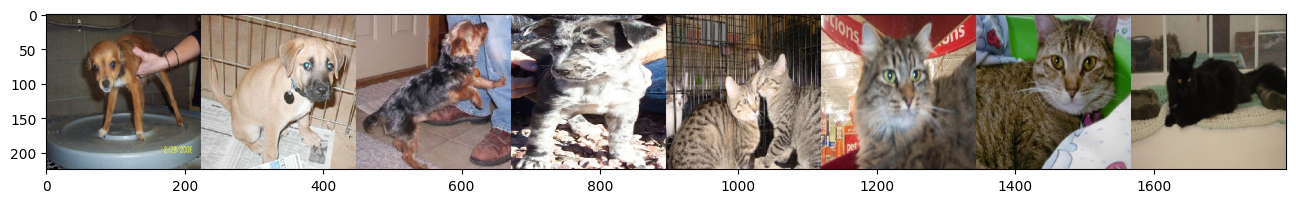

In [34]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)          

Construindo rede de treinamento do zero

In [35]:
# Constuindo rede
model = Sequential()
print("Input dimensions: ", x_train.shape[1:])

model.add(Conv2D(32, (3,3), input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                

In [36]:
# Compilando o modelo para usar a função de perda de entropia cruzada categórica e o otimizador adadelta
model.compile(loss="categorical_crossentropy", # função de perda categorical_crossentropy
              optimizer="adam", # Otimizador Adam
              metrics=["accuracy"]) # Métrica de acurácia

history = model.fit(x_train, y_train, # Dados e rótulos de treinamento
                    batch_size = 50, # Tamanho do lote para cada iteração de treinamento
                    epochs = 10, # Números de épocas para treinar o modelo
                    validation_data = (x_val, y_val)) # Daos de validação para avaliar o modelo em cada época


Epoch 1/10
28/28 [==============================] - 25s 830ms/step - loss: 0.6937 - accuracy: 0.5011 - val_loss: 0.6799 - val_accuracy: 0.5300
Epoch 2/10
28/28 [==============================] - 21s 741ms/step - loss: 0.6708 - accuracy: 0.5747 - val_loss: 0.6570 - val_accuracy: 0.6200
Epoch 3/10
28/28 [==============================] - 26s 916ms/step - loss: 0.6480 - accuracy: 0.6162 - val_loss: 0.6475 - val_accuracy: 0.5933
Epoch 4/10
28/28 [==============================] - 25s 897ms/step - loss: 0.6158 - accuracy: 0.6447 - val_loss: 0.6258 - val_accuracy: 0.6333
Epoch 5/10
28/28 [==============================] - 24s 859ms/step - loss: 0.5738 - accuracy: 0.7055 - val_loss: 0.6006 - val_accuracy: 0.6767
Epoch 6/10
28/28 [==============================] - 23s 803ms/step - loss: 0.5235 - accuracy: 0.7441 - val_loss: 0.6040 - val_accuracy: 0.6933
Epoch 7/10
28/28 [==============================] - 22s 792ms/step - loss: 0.4827 - accuracy: 0.7720 - val_loss: 0.5884 - val_accuracy: 0.6900

Plotando validação e a precisão ao longo do tempo

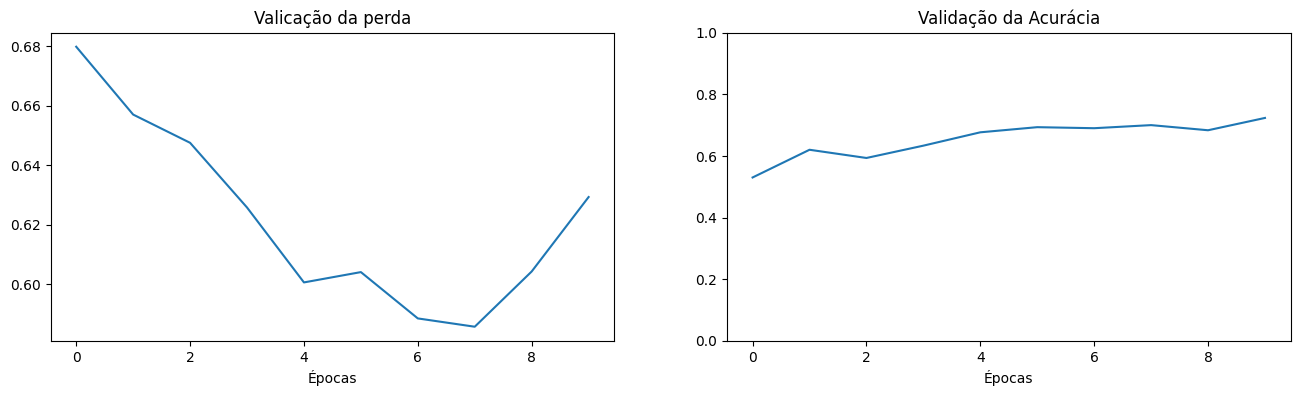

In [37]:
# Figura principal
fig = plt.figure(figsize=(16,4))

# 
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Valicação da perda")
ax.set_xlabel("Épocas")

# Gráfico 2
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validação da Acurácia")
ax2.set_xlabel("Épocas")
ax2.set_ylim(0, 1)

plt.show()


In [38]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Teste de perda:", loss)
print("Teste de Accurácia: ", accuracy)

Teste de perda: 0.6416875123977661
Teste de Accurácia:  0.6733333468437195


Utilizando uma rede existente e pré-treinada

In [39]:
# Carregando os dados do keras
vgg = keras.applications.VGG16(weights="imagenet", include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [40]:
# Referência a camada de entraada VGG
inp = vgg.input

# Criando uma nova camada softmax com num_classes neurônios
new_classification_layer = Dense(num_classes, activation="softmax")

# Conectando a nova camada à penúltima camada do VGG e fazendo referência a ela
out = new_classification_layer(vgg.layers[-2].output)

# Criando uma nova rede entre inp e out
model_new = Model(inp, out)

In [41]:
# Tornando todas as camadas não treináveis, congelandos os pesos, (exceto pela última camada)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Garantindo que a última camada seja não treinável / não congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trenable = True

model_new.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=50,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
28/28 [==============================] - 283s 10s/step - loss: 0.7921 - accuracy: 0.5554 - val_loss: 0.4986 - val_accuracy: 0.7300
Epoch 2/10
28/28 [==============================] - 258s 9s/step - loss: 0.4598 - accuracy: 0.7784 - val_loss: 0.3833 - val_accuracy: 0.8700
Epoch 3/10
28/28 [==============================] - 256s 9s/step - loss: 0.3720 - accuracy: 0.8449 - val_loss: 0.3245 - val_accuracy: 0.8967
Epoch 4/10
28/28 [==============================] - 255s 9s/step - loss: 0.3263 - accuracy: 0.8728 - val_loss: 0.2986 - val_accuracy: 0.9067
Epoch 5/10
28/28 [==============================] - 255s 9s/step - loss: 0.3118 - accuracy: 0.8821 - val_loss: 0.2741 - val_accuracy: 0.9233
Epoch 6/10
28/28 [==============================] - 255s 9s/step - loss: 0.3013 - accuracy: 0.8863 - val_loss: 0.2561 - val_accuracy: 0.9233
Epoch 7/10
28/28 [==============================] - 256s 9s/step - loss: 0.2741 - accuracy: 0.8978 - val_loss: 0.2455 - val_accuracy: 0.9233
Epoch 8/10
2

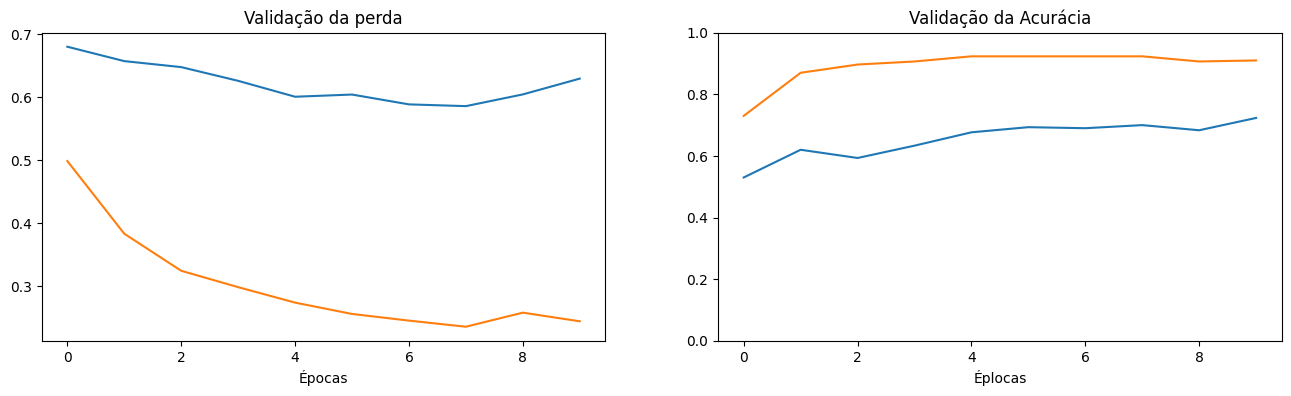

In [43]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("Validação da perda")
ax.set_xlabel("Épocas")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("Validação da Acurácia")
ax2.set_xlabel("Éplocas")
ax2.set_ylim(0, 1)

plt.show()

In [44]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)
print("Teste de perda: ", loss)
print("Teste de acurácia: ", accuracy)

Teste de perda:  0.25138717889785767
Teste de acurácia:  0.9166666865348816


Aplicando modelo em uma imagem

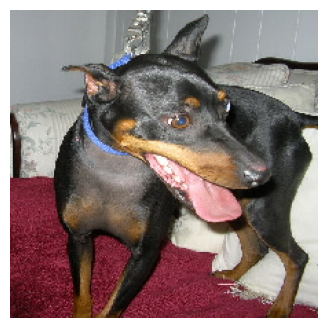

1/1 [==============================] - 1s 538ms/step
[[4.906393e-13 1.000000e+00]]


In [45]:
img, x = get_image("PetImages/Dog/13.jpg")

 # Mostrar a imagem carregada no tamanho desejado
plt.figure(figsize=(16, 4))
plt.imshow(img)
plt.axis('off') # Esconde os eixos
plt.show()

probabilidade = model_new.predict([x])
print(probabilidade)